In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from generate_data import generate_Ls, generate_sylvester_data
from proximal_gradient_descent import (
    get_optimizer_oracles,
    proximal_accelerated_gradient,
    project_to_lower_with_positive_diag,
    warm_start
)
from plotting_utilities import get_metrics, patternify_Ls, one_example_prs
from sklearn.metrics import precision_score, recall_score, matthews_corrcoef, auc
import pickle

# Prevent Type 3 fonts
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [150]:
np.random.seed(0)
dims = (3, 3)
sparsity = 0.1
true_Ls = [
    np.array([[1, 0, 0], [0, 1, 0], [0.2, 0.5, 1]]),
    np.array([[1, 0, 0], [0, 1, 0], [0.2, 0.5, 1]])
]
X = generate_sylvester_data(true_Ls, normalize=True, source_distribution=np.random.normal)

orderings = {
    "abc": [0, 1, 2],
    "acb": [0, 2, 1],
    "bac": [1, 0, 2],
    "bca": [1, 2, 0],
    "cab": [2, 0, 1],
    "cba": [2, 1, 0]
}

all_patterns = dict()

for name, ordering in orderings.items():
    inverse_ordering = np.argsort(ordering)

    # Re-order the features in X according to the specified ordering
    _X = X[:, ordering].copy()


    patterns_1 = []
    patterns_2 = []

    L_init = [np.eye(d) for d in dims]

    frobreg = 1/np.prod(dims)**(1/len(dims))
    glassoregs = np.logspace(-2, 0.5, 100)

    for glassoreg in glassoregs:
        objective, gradient, proximal = get_optimizer_oracles(_X, frobreg=frobreg, glassoregs=glassoreg)

        Ls, (_, eps, _, _) = proximal_accelerated_gradient(
            f=objective,
            del_f=gradient,
            prox=proximal,
            P=project_to_lower_with_positive_diag,
            Ls=L_init,
            mu=0.2,
            init_alpha=1,
            tau=0.5,
            beta=0.0001,
            max_iter=100,
            tol=1e-5
        )

        # Recover the original features axis
        Ls[1] = Ls[1][inverse_ordering][:, inverse_ordering]

        patterns_1.append(Ls[0][np.tril_indices_from(Ls[0], k=-1)])
        patterns_2.append(Ls[1][np.tril_indices_from(Ls[1], k=-1)])

    all_values = {
        "a--b on axis 1": [p[0] for p in patterns_1],
        "a--c on axis 1": [p[1] for p in patterns_1],
        "b--c on axis 1": [p[2] for p in patterns_1],
        "a--b on axis 2": [p[0] for p in patterns_2],
        "a--c on axis 2": [p[1] for p in patterns_2],
        "b--c on axis 2": [p[2] for p in patterns_2],
    }

    all_patterns[name] = all_values


In [102]:
with open("results/patterns.pickle", "wb") as f:
    pickle.dump(all_patterns, f)

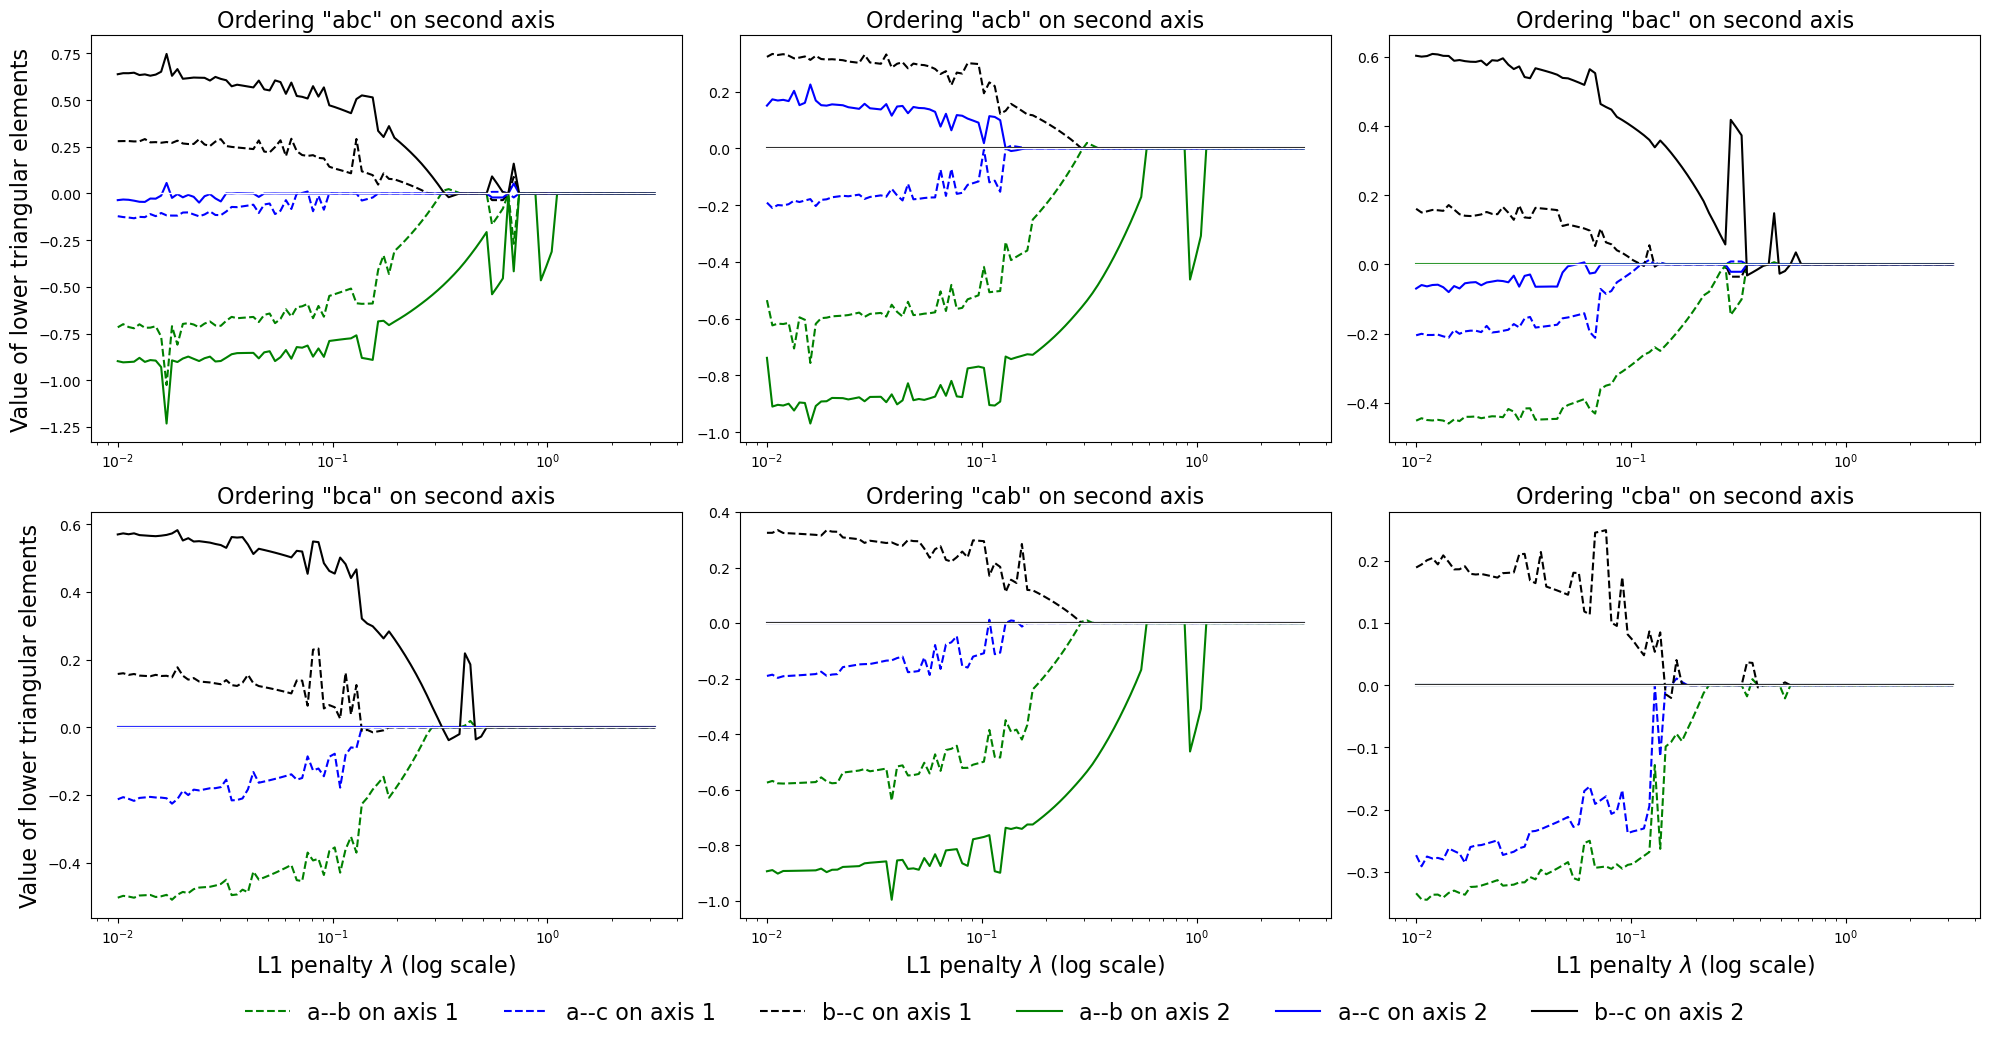

In [151]:


fig, axs = plt.subplots(figsize=(20, 10), ncols=3, nrows=2)
axs = axs.flatten()

for idx, (name, ax) in enumerate(zip(all_patterns.keys(), axs)):
    for idx2, (label, values) in enumerate(all_patterns[name].items()):
        linestyle = '-' if idx2 > 2 else '--'
        color = ['green', 'blue', 'black'][idx2 % 3]
        ax.plot(glassoregs, values, label=label, linestyle=linestyle, color=color)

    ax.set_xscale('log')

    if idx > 2:
        # only draw x axis on bottom row
        ax.set_xlabel(r'L1 penalty $\lambda$ (log scale)', fontsize=16)
    if idx % 3 == 0:
        # only draw y axis on first column
        ax.set_ylabel('Value of lower triangular elements', fontsize=16)
    ax.set_title(f'Ordering "{name}" on second axis', fontsize=16)
    ax.axhline(0, color='white', linewidth=1)

# Get one legend for all subplots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=6, fontsize=16, bbox_to_anchor=(0.5, -0.05), frameon=False)
fig.tight_layout()

In [199]:
np.random.seed(0)
dims = (10, 10, 3)
sparsity = 1
true_Ls, _ = generate_Ls(dims, sparsity=sparsity)
true_Ls[-1][1, 0] = 0 # make a->b be zero
X = generate_sylvester_data(true_Ls, normalize=True, source_distribution=np.random.normal)

orderings = {
    "abc": [0, 1, 2],
    "acb": [0, 2, 1],
    "bac": [1, 0, 2],
    "bca": [1, 2, 0],
    "cab": [2, 0, 1],
    "cba": [2, 1, 0]
}

all_patterns = dict()

for name, ordering in orderings.items():
    inverse_ordering = np.argsort(ordering)

    # Re-order the features in X according to the specified ordering
    _X = X[..., ordering].copy()


    patterns_2 = []

    L_init = [np.eye(d) for d in dims]

    frobreg = 0.1
    glassoregs = np.logspace(-1, 1, 10)

    for glassoreg in glassoregs:
        objective, gradient, proximal = get_optimizer_oracles(_X, frobreg=frobreg, glassoregs=glassoreg)

        Ls, (_, eps, _, _) = proximal_accelerated_gradient(
            f=objective,
            del_f=gradient,
            prox=proximal,
            P=project_to_lower_with_positive_diag,
            Ls=L_init,
            mu=0.2,
            init_alpha=1,
            tau=0.5,
            beta=0.0001,
            max_iter=100,
            tol=1e-5
        )

        # Recover the original features axis
        indices = np.tril_indices_from(Ls[-1], k=-1)
        #Ls[-1] = Ls[-1][inverse_ordering][:, inverse_ordering]
        indices = (
            indices[0][inverse_ordering],
            indices[1][inverse_ordering]
        )
        patterns_2.append(Ls[-1][indices])

    all_values = {
        r"a$\leftrightarrow$b on last axis": [p[0] for p in patterns_2],
        r"a$\leftrightarrow$c on last axis": [p[1] for p in patterns_2],
        r"b$\leftrightarrow$c on last axis": [p[2] for p in patterns_2],
    }

    all_patterns[name] = all_values


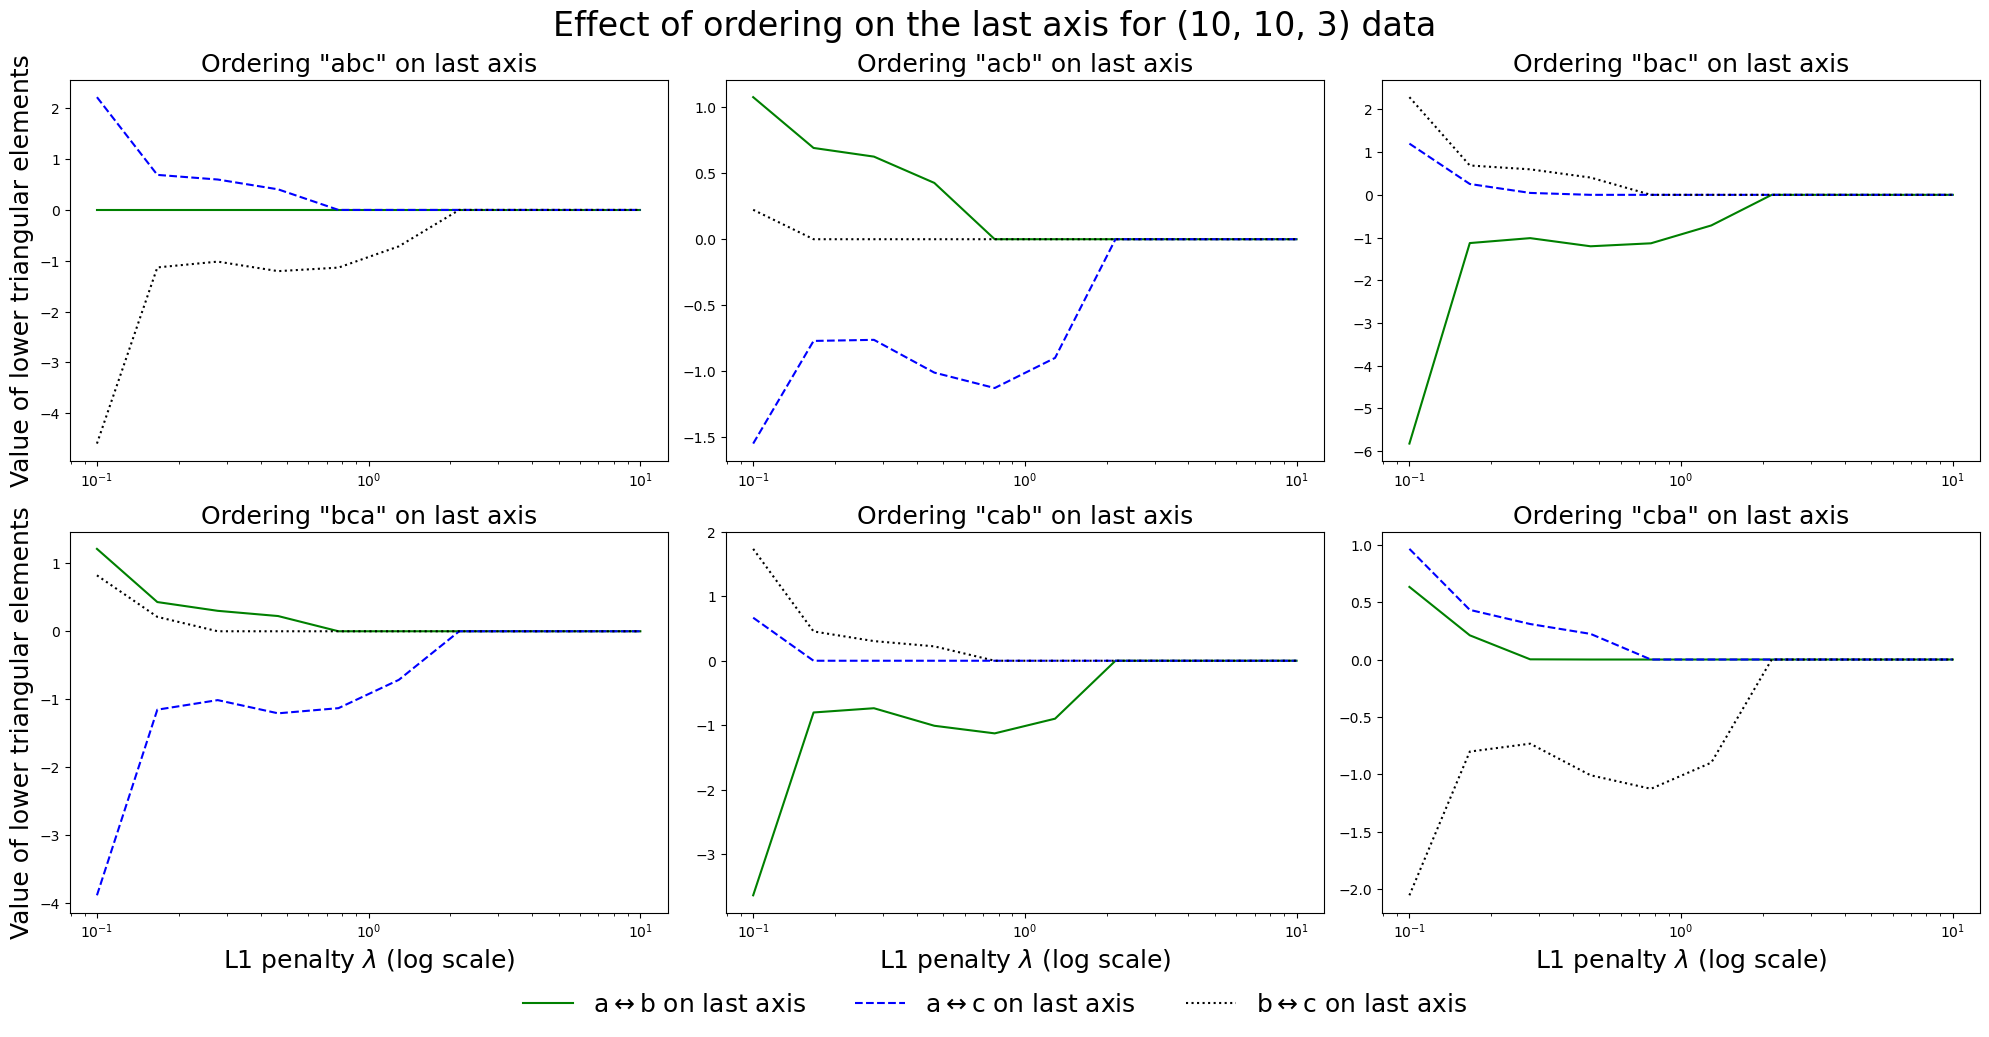

In [200]:
fig, axs = plt.subplots(figsize=(20, 10), ncols=3, nrows=2)
axs = axs.flatten()

for idx, (name, ax) in enumerate(zip(all_patterns.keys(), axs)):
    for idx2, (label, values) in enumerate(all_patterns[name].items()):
        color = ['green', 'blue', 'black'][idx2]
        linestyle = ['-', '--', ':'][idx2]
        ax.plot(glassoregs, values, label=label, linestyle=linestyle, color=color)

    ax.set_xscale('log')

    if idx > 2:
        # only draw x axis on bottom row
        ax.set_xlabel(r'L1 penalty $\lambda$ (log scale)', fontsize=18)
    if idx % 3 == 0:
        # only draw y axis on first column
        ax.set_ylabel('Value of lower triangular elements', fontsize=18)
    ax.set_title(f'Ordering "{name}" on last axis', fontsize=18)
    #ax.axhline(0, color='white', linewidth=1)

# Get one legend for all subplots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=6, fontsize=18, bbox_to_anchor=(0.5, -0.05), frameon=False)
fig.suptitle('Effect of ordering on the last axis for (10, 10, 3) data', fontsize=24)
fig.tight_layout()

In [201]:
fig.savefig("figures/effect_of_ordering.pdf", bbox_inches='tight')

## Full table test